In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string


In [3]:
#------------------------Load Data from file and Transform to Pandas Data Fram---------------------#

l_Comments = []                                                # The text messages are inserted in the file.
l_Message = []                                                # The messages extracted from the text file.
l_Label = []                                                  # The labels extracted from the text file.
d_Transform_data={}                                           # The dictionary to transform the messages and labels into a Pandas DataFrame.
l_Stat=[]                                                     # It is a static variable to keep track of the counter for any station in the process of transforming and cleaning the data.
with open("test.txt", 'r', encoding='utf-8') as file:
        for line in file:
            x = line.partition("__label__")                   #Removing the "__label__" from the comments.
            l_Comments.append(x[2:])                           #Insert the comment into the l_Comment variable.
        pass
l_Stat.append(len(l_Comments))                                 #Store the number of comments
file.close()
for comment in l_Comments:
        l_Label.append(comment[0].split()[0])                 #Extract labels from the comments
        l_Message.append(' '.join(comment[0].split()[1:]))    #Extract messages from the comments.
d_Transform_data = {"Text":l_Message,"Label":l_Label}               #Load from a list into a dictionary.
df_Main = pd.DataFrame(d_Transform_data)                     #Transform from a dictionary to a Pandas Data Frame.
l_Stat.append(len(df_Main))                                  #Store the number of Dataframe rows 


In [4]:
#----------------------Preprocessing the DataFrame to prepare it for cleaning.----------------------#

df_Main['Label'] = df_Main['Label'].astype(int)              #Convert the type of the label into an integer.
df_Main['Label'] = df_Main['Label'].apply(lambda x: 0 if x==1 else 1) #Change all labels to 0 and 1. 
df_Main.dropna(inplace=True)                                 #Remove any null entries from the DataFrame.     
l_Stat.append(len(df_Main))                                  #Store the number of not null dataframe rows
df_Main.to_csv('First_data.txt', index=False, sep='\t')  # Store the DataFrame into a text file with a tab ('\t') as the separator.

In [5]:
#---------------------Define the function to preprocess the data -----------------------------------#

def f_preprocess_df(data):                                    #Define the function to preprocess of Text  
    text=str(data)                                            #Convert all text to strings
    text=text.lower()                                         #Convert to lowercase characters
    text=re.sub(r'[^a-zA-Z0-9\s]','',text)                    #Remove special characters
    text=re.sub(r'(http|https)?://\S+|www\.\S+','',text)      #Remove any links
    text=re.sub(r'[^\w\s]','',text)                           #Remove punctuation
    text = re.sub(r'[\d]+','',text)                           #Remove digits
    text=re.sub(r'\b\w\b','',text)                            #Remove single characters
    text=re.sub(r'\s{2,}','',text)                            #Remove multiple spaces
    return text


In [6]:
#-------------------Applying the function to the Data Frame ----------------------------------------#

df_copy = df_Main.copy()                                       #Copy to a spare Data Frame to keep the main data frame
df_copy.loc[:,"Text"] = df_copy["Text"].apply(f_preprocess_df) # Applying the preprocess function to a copy of the data frame
df_copy.head()

,Text,Label
0,great cd my lovely pat has one of the great vo...,1
1,one of the best game music soundtracksforgamed...,1
2,batteries died withinyearbought this charger i...,0
3,works fine but maha energy is better check out...,1
4,great for the nonaudiophile reviewed quitebit ...,1


## EDA

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [8]:
import os
for dirname, _, filenames in os.walk('C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\amazon_review_full_csv.tar.gz
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\archive.zip
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\data-visualization-dnn-gru-cnn.ipynb
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\Final_Jefford_-Eda.ipynb
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\Final_Keyvan_-checkpoint.ipynb
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\First_data.txt
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\GitHub.vscode-pull-request-github-0.76.1.vsix
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\Keyvan_Section_1-checkpoint.ipynb
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\SentimentAnalysis.ipynb
C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT\test.csv
C:/Term3/PYTHON/T3 AML 2304 - Natural Language 

In [9]:
import bz2
import pandas as pd
import re 
import numpy as np

In [10]:
train_file = bz2.BZ2File('C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT/train.ft.txt.bz2')
test_file = bz2.BZ2File('C:/Term3/PYTHON/T3 AML 2304 - Natural Language Processing 01/PROJECT/train.ft.txt.bz2')

In [11]:
#Reading Data set
train_file = train_file.readlines()
test_file = test_file.readlines()


In [12]:
print("Number of training reviews: " + str(len(train_file)))
print("Number of test reviews: " + str(len(test_file)))

Number of training reviews: 3600000
Number of test reviews: 3600000


In [13]:
#training on the first 10000 reviews in the  dataset
num_train = 250000
#Using 2000 reviews from test set
num_test = 20000#Using 200,000 reviews from test set

train_file = [x.decode('utf-8') for x in train_file[:num_train]]
test_file = [x.decode('utf-8') for x in test_file[:num_test]]

In [14]:
#Extracing Labels and Review from traing Dataset
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

In [15]:
#Extracing Labels and Review from test Dataset
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

In [16]:
train = pd.DataFrame({'text':train_sentences,'label':train_labels})
test=pd.DataFrame({'text':test_sentences,'label':test_labels})

In [17]:
train.head()

,text,label
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1


In [18]:
train.describe()

,label
count,250000.000000
mean,0.508832
std,0.499923
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [19]:
train['number_of_words'] = train['text'].str.lower().str.split().apply(len)
train.head()

,text,label,number_of_words
0,stuning even for the non-gamer: this sound tra...,1,80
1,the best soundtrack ever to anything.: i'm rea...,1,97
2,amazing!: this soundtrack is my favorite music...,1,129
3,excellent soundtrack: i truly like this soundt...,1,118
4,"remember, pull your jaw off the floor after he...",1,87


<AxesSubplot: xlabel='label', ylabel='count'>

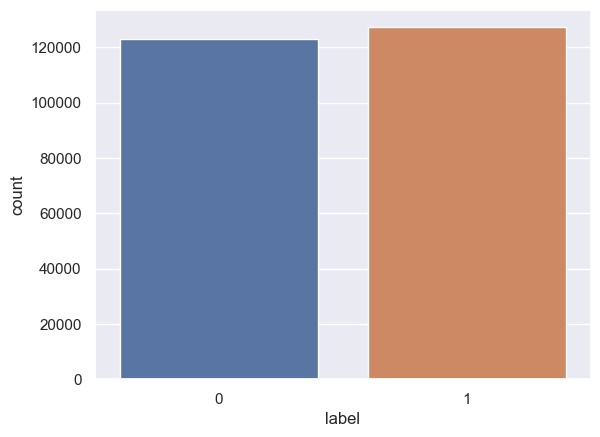

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="label", data=train)

<AxesSubplot: ylabel='Frequency'>

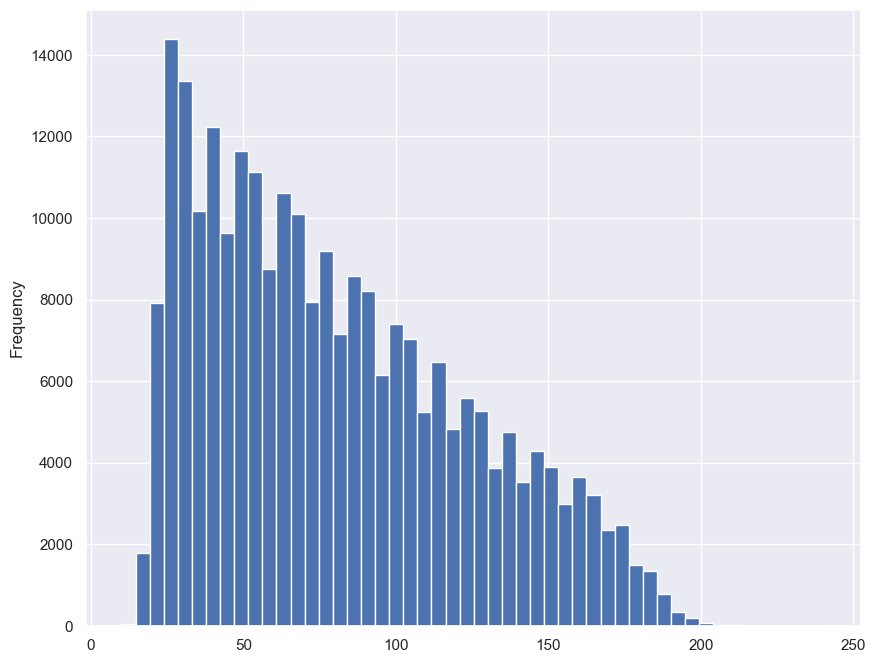

In [21]:
train['number_of_words'].plot(bins=50, kind='hist',figsize = (10,8)) 

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

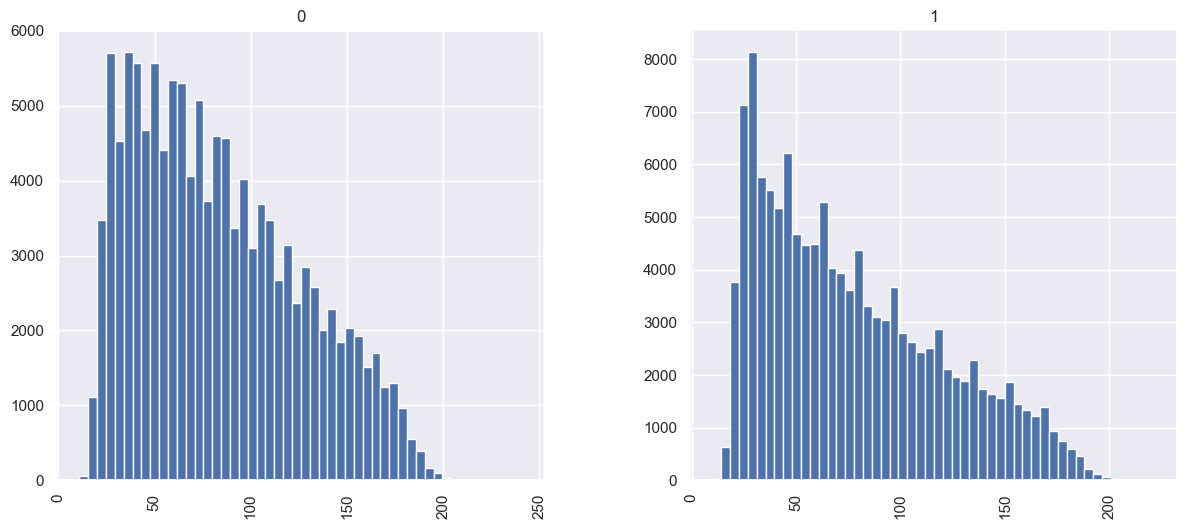

In [22]:
train.hist(column='number_of_words', by='label',
           bins=50,figsize=(14,6))

In [23]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

In [24]:
# Language detection function
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

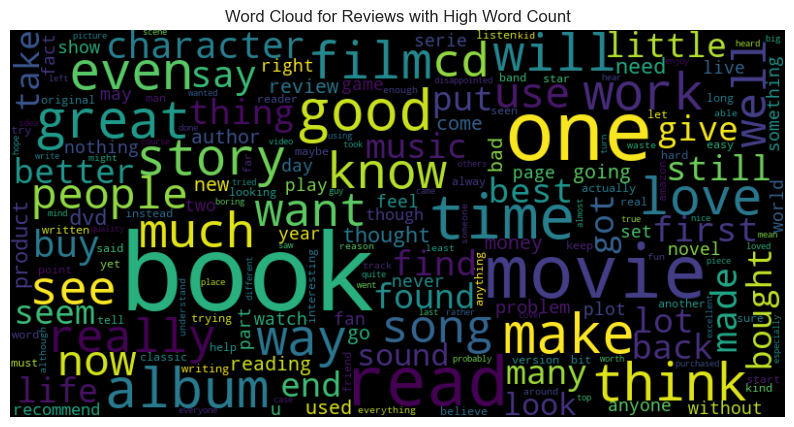

In [26]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Count the number of words in each review
train['number_of_words'] = train['text'].str.lower().str.split().apply(len)
test['number_of_words'] = test['text'].str.lower().str.split().apply(len)

# Visualize the high count of words using a word cloud
high_word_count_reviews = train[train['number_of_words'] > 100]  # Adjust the threshold as needed

text = ' '.join(high_word_count_reviews['text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Reviews with High Word Count')
plt.show()

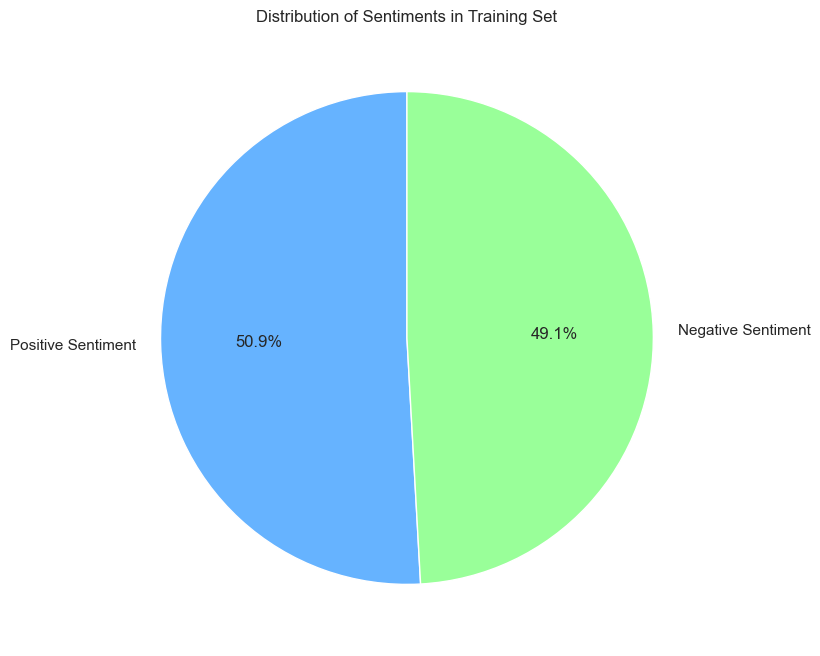

In [27]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Count the number of positive and negative sentiments
positive_count = train[train['label'] == 1].shape[0]
negative_count = train[train['label'] == 0].shape[0]

# Create a pie chart
labels = ['Positive Sentiment', 'Negative Sentiment']
sizes = [positive_count, negative_count]
colors = ['#66b3ff', '#99ff99']  # Blue for positive, Green for negative

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiments in Training Set')
plt.show()

In [28]:
from langdetect import detect

In [29]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to the training and test datasets
train['language'] = train['text'].apply(detect_language)
test['language'] = test['text'].apply(detect_language)

# Filter out non-English words
non_english_words_train = train[train['language'] != 'en']['text']
non_english_words_test = test[test['language'] != 'en']['text']

# Display non-English words
print("Non-English words in the training set:")
print(non_english_words_train)

print("\nNon-English words in the test set:")
print(non_english_words_test)

Non-English words in the training set:
123       este libro contiene todo: lo que pense que no ...
881       good read................. ............... ......
1249      il grande ritorno!: e' dai tempi del tour di "...
1259      la reencarnación vista por un científico: el p...
1260      excelente libro / amazing book!!: este libro h...
                                ...                        
248382    en concierto inolvidable: este concierto y el ...
248677    world music com sabor rítmico delicioso: há ma...
248714    santana: se te extraña en el pasado.: santana ...
249920    el primer instinto: una recopilacion de exitos...
249922    jaguares, el primer instinto: la más nueva pro...
Name: text, Length: 544, dtype: object

Non-English words in the test set:
123      este libro contiene todo: lo que pense que no ...
881      good read................. ............... ......
1249     il grande ritorno!: e' dai tempi del tour di "...
1259     la reencarnación vista por un científico

Language frequency in the training set:
en    249460
es       407
fr        38
pt        24
af        14
de        10
it         9
nl         7
da         5
tl         3
hr         3
so         3
sl         3
cy         3
hu         3
id         2
pl         2
fi         1
sq         1
no         1
vi         1
Name: language, dtype: int64

Language frequency in the test set:
en    19948
es       35
fr       10
it        2
de        2
cy        1
id        1
sq        1
Name: language, dtype: int64


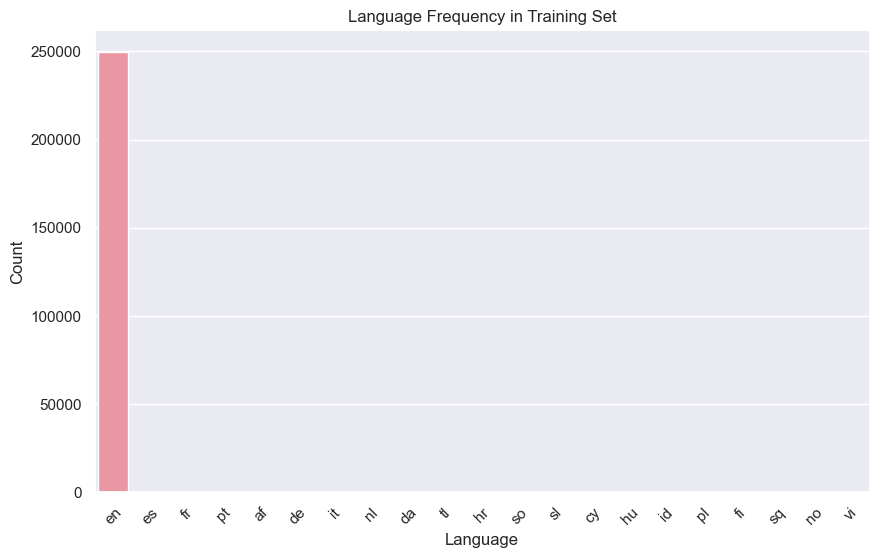

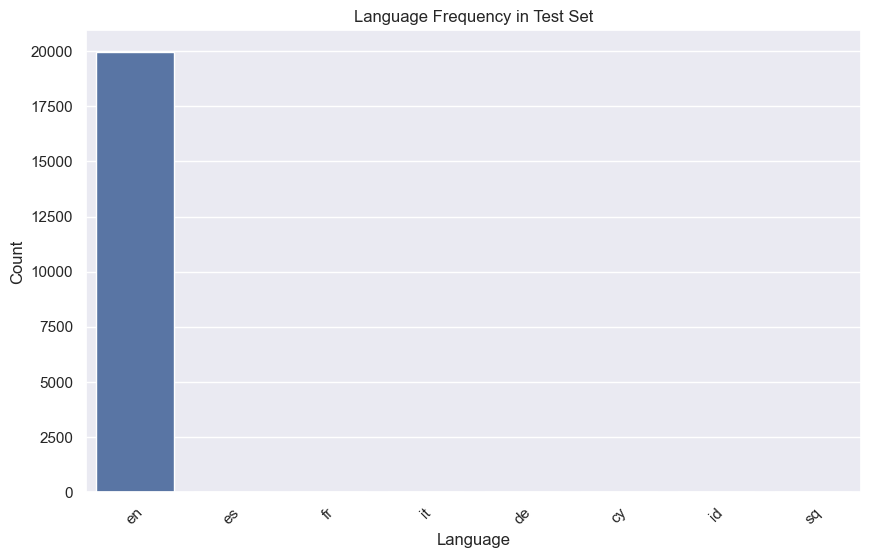

In [30]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to the training and test datasets
train['language'] = train['text'].apply(detect_language)
test['language'] = test['text'].apply(detect_language)

# Count the frequency of each language
language_counts_train = train['language'].value_counts()
language_counts_test = test['language'].value_counts()

# Display language frequency
print("Language frequency in the training set:")
print(language_counts_train)

print("\nLanguage frequency in the test set:")
print(language_counts_test)

# Visualize language frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts_train.index, y=language_counts_train.values)
plt.title('Language Frequency in Training Set')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts_test.index, y=language_counts_test.values)
plt.title('Language Frequency in Test Set')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Language frequency in the training set:
English       249459
Espanol          406
French            38
Portuguese        24
Other             11
Afrikaans         11
Italian           11
German            10
Dutch              7
Danish             6
Croatian           4
Somali             4
Welsh              3
Indonesian         2
Hungarian          2
Albanian           1
Finnish            1
Name: language_label, dtype: int64

Language frequency in the test set:
English       19948
Espanol          34
French           10
Italian           2
German            2
Welsh             1
Indonesian        1
Albanian          1
Afrikaans         1
Name: language_label, dtype: int64


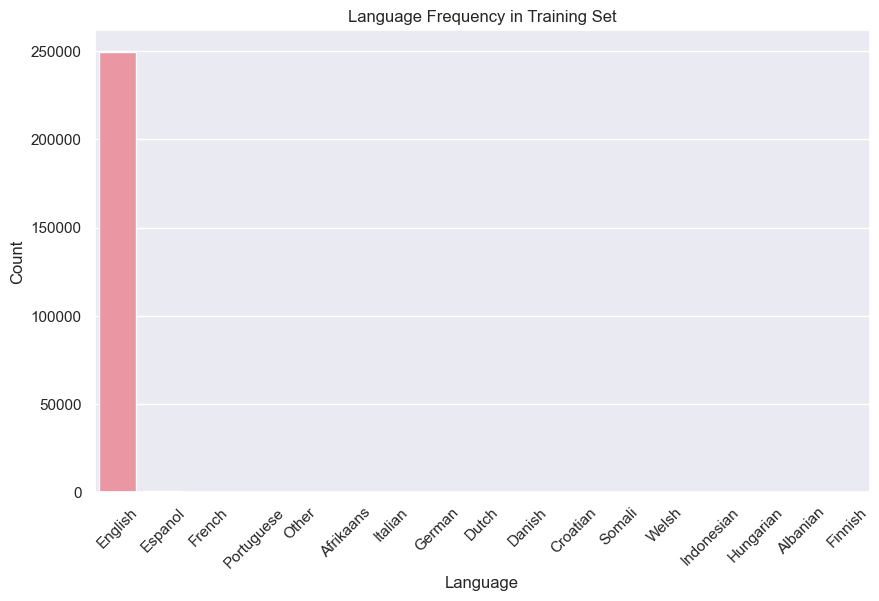

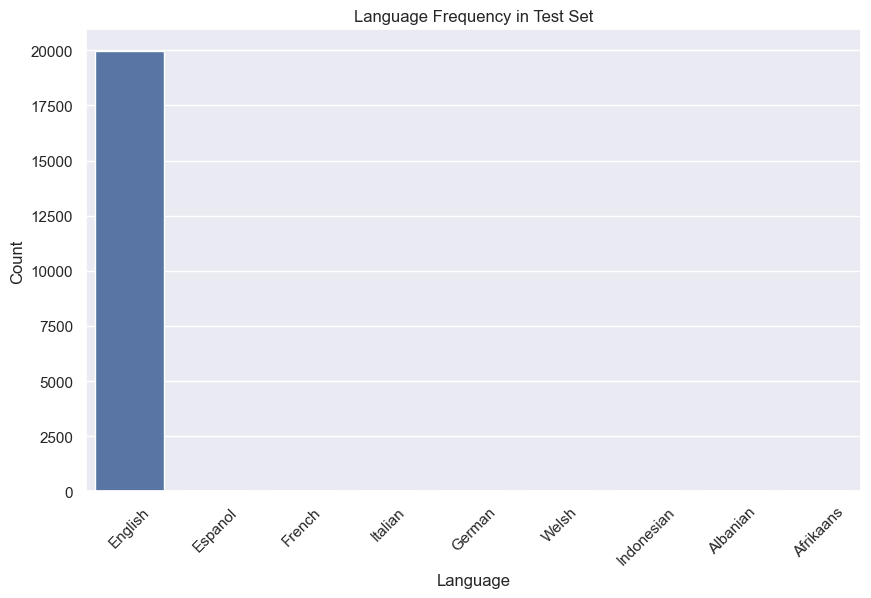

In [31]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Function to map language codes to labels
def map_language_label(language_code):
    language_mapping = {
        'en': 'English',
        'es': 'Espanol',
        'fr': 'French',
        'it': 'Italian',
        'af': 'Afrikaans',
        'pt': 'Portuguese',
        'de': 'German',
        'nl': 'Dutch',
        'cy': 'Welsh',
        'hr': 'Croatian',
        'so': 'Somali',
        'id': 'Indonesian',
        'sq': 'Albanian',
        'da': 'Danish',
        'fi': 'Finnish',
        'hu': 'Hungarian',
        # Add more language codes and labels as needed
    }
    return language_mapping.get(language_code, 'Other')

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to the training and test datasets
train['language'] = train['text'].apply(detect_language)
test['language'] = test['text'].apply(detect_language)

# Map language codes to labels
train['language_label'] = train['language'].apply(map_language_label)
test['language_label'] = test['language'].apply(map_language_label)

# Count the frequency of each language
language_counts_train = train['language_label'].value_counts()
language_counts_test = test['language_label'].value_counts()

# Display language frequency
print("Language frequency in the training set:")
print(language_counts_train)

print("\nLanguage frequency in the test set:")
print(language_counts_test)

# Visualize language frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts_train.index, y=language_counts_train.values)
plt.title('Language Frequency in Training Set')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts_test.index, y=language_counts_test.values)
plt.title('Language Frequency in Test Set')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


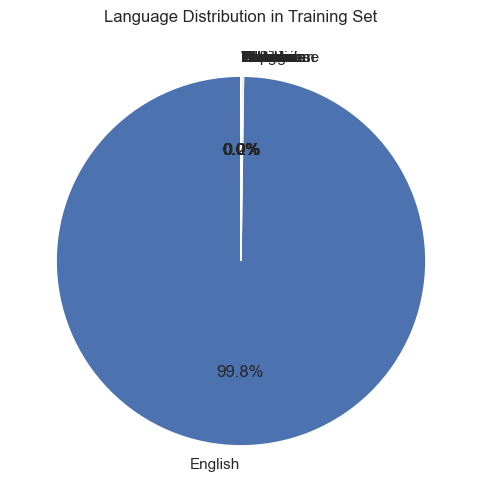

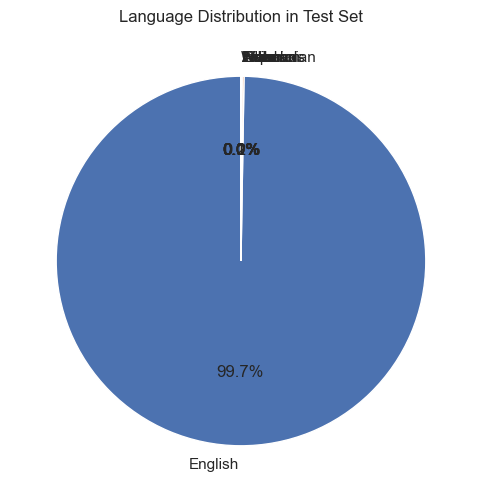

In [32]:
# Apply language detection to the training and test datasets
train['language'] = train['text'].apply(detect_language)
test['language'] = test['text'].apply(detect_language)

# Map language codes to labels
train['language_label'] = train['language'].apply(map_language_label)
test['language_label'] = test['language'].apply(map_language_label)

# Count the frequency of each language
language_counts_train = train['language_label'].value_counts()
language_counts_test = test['language_label'].value_counts()

# Display language frequency in percentage
language_percentage_train = (language_counts_train / language_counts_train.sum()) * 100
language_percentage_test = (language_counts_test / language_counts_test.sum()) * 100

# Visualize language frequency in percentage using pie chart
plt.figure(figsize=(10, 6))
plt.pie(language_percentage_train, labels=language_percentage_train.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution in Training Set')
plt.show()

plt.figure(figsize=(10, 6))
plt.pie(language_percentage_test, labels=language_percentage_test.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution in Test Set')
plt.show()

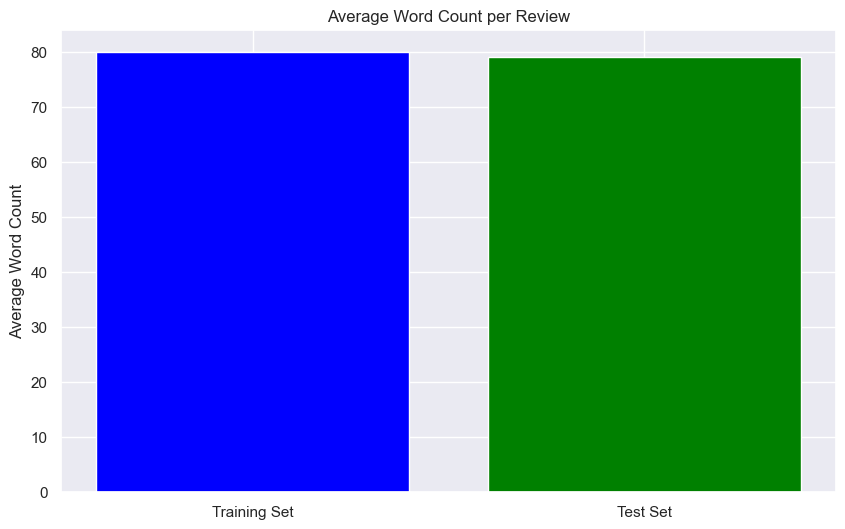

Average word count per review in the training set: 80.10
Average word count per review in the test set: 79.19


In [33]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Calculate the number of words in each review
train['number_of_words'] = train['text'].str.lower().str.split().apply(len)
test['number_of_words'] = test['text'].str.lower().str.split().apply(len)

# Calculate the average word count per review
average_word_count_train = train['number_of_words'].mean()
average_word_count_test = test['number_of_words'].mean()

# Visualize the average word count
plt.figure(figsize=(10, 6))
plt.bar(['Training Set', 'Test Set'], [average_word_count_train, average_word_count_test], color=['blue', 'green'])
plt.title('Average Word Count per Review')
plt.ylabel('Average Word Count')
plt.show()

print(f"Average word count per review in the training set: {average_word_count_train:.2f}")
print(f"Average word count per review in the test set: {average_word_count_test:.2f}")

In [34]:
from collections import Counter

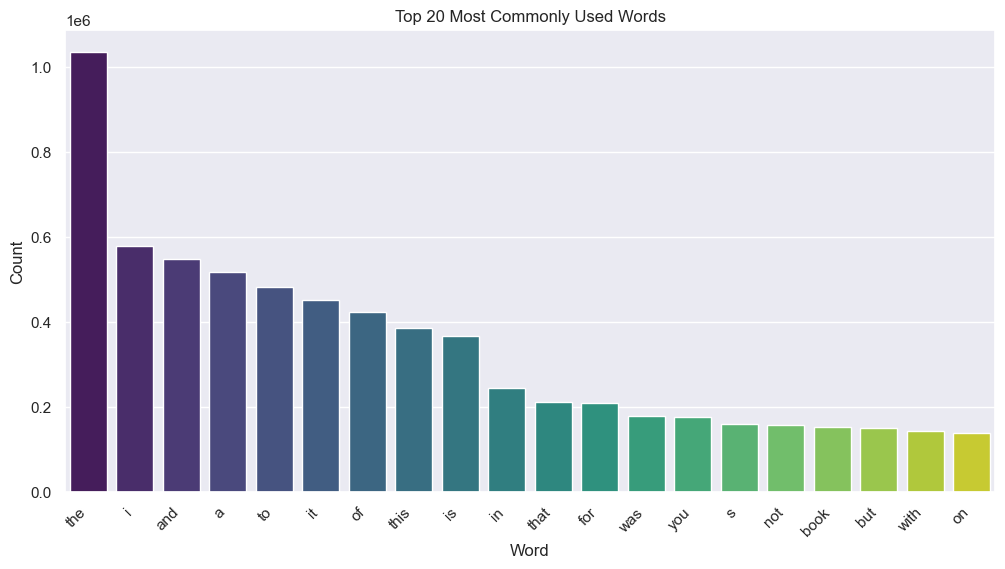

In [35]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Combine all reviews into a single string
all_text = ' '.join(train['text'])

# Tokenize words
words = re.findall(r'\b\w+\b', all_text)

# Count the frequency of each word
word_counts = Counter(words)

# Get the top N most common words
top_words = word_counts.most_common(20)  # Change 20 to the desired number of top words

# Convert the result into a DataFrame for easy plotting
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Count', data=top_words_df, palette='viridis')
plt.title('Top 20 Most Commonly Used Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

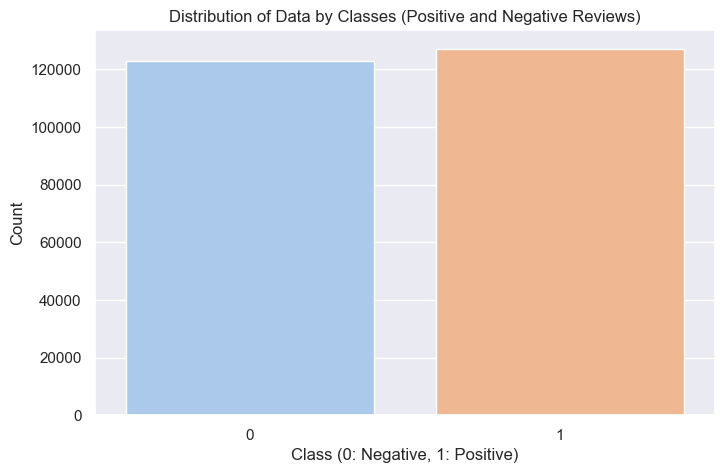

In [36]:
# Extracting sentences and labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

train = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test = pd.DataFrame({'text': test_sentences, 'label': test_labels})

# Plot the distribution of data by classes
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train, palette='pastel')
plt.title('Distribution of Data by Classes (Positive and Negative Reviews)')
plt.xlabel('Class (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

In [37]:

# Check for null values in the training set
train_null = train.isnull().sum()

# Check for null values in the test set
test_null = test.isnull().sum()

# Print the results
print("Null values in the training set:")
print(train_null)

print("\nNull values in the test set:")
print(test_null)

Null values in the training set:
text     0
label    0
dtype: int64

Null values in the test set:
text     0
label    0
dtype: int64
